Comparison of SVD-MCMC and optimization-based approach
======================================================

We performed a first comparison of the optimization-based approach with the Prashin's
SVD-based MCMC for performing blob detection.

For this, we worked with *simulated data* from an artificial ground truth (a random
Gaussian mixture) for the stellar distribution function. Here some basic infos:

- Signal-to-noise ratio: 1000
- Regularization operator: Ornstein-Uhlenbeck
- Regularization parameter: Determined by hand-tuning.
- $\theta_v$: Fixed at ground truth.
- Sum-to-one-constraint? No.

In [2]:
# Some general imports.
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from pathlib import Path

SVD-MCMC
--------

We sampled from the posterior distribution using the following parameters.

- Burnin for $\eta, \alpha$: 10000
- Number of samples for $\eta, \alpha$: 10000
- Burnin for $\tilde \beta$: 5000
- Number of samples for $\tilde \beta$: 5000
- $q = 15$
- $\sigma_\alpha = 0.1$
- $\sigma_\eta = 0.1$


In [3]:
beta_samples = np.load("out/samples.npy")
beta_samples.shape

(5000, 636)

Let us look at some samples.

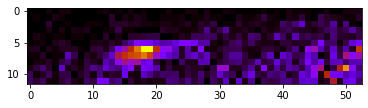

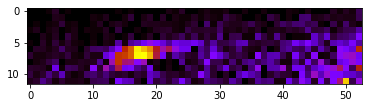

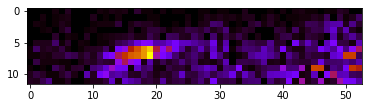

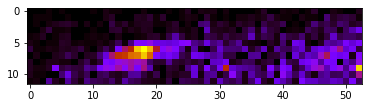

In [4]:
n = beta_samples.shape[0]
random_indices = np.random.randint(low=0, high=n, size=4)
some_samples = beta_samples[random_indices]

for sample in some_samples:
    plt.imshow(sample.reshape(12, 53), cmap="gnuplot")
    plt.show()

I don't know, shouldn't they look smoother?

Anyways, from these samples we can compute various point estimates. Let us look at the posterior mean
and the posterior [geometric median](https://en.wikipedia.org/wiki/Geometric_median).
In our case, they appear to be identical:

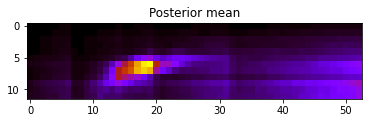

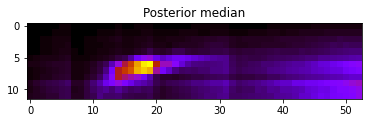

In [5]:
from make_figures.mcmc_comparison.geometric_median import geometric_median

posterior_mean = np.mean(beta_samples, axis=0).reshape(12, 53)
posterior_median = geometric_median(X=beta_samples, eps=1e-8).reshape(12, 53)

plt.imshow(posterior_mean, cmap="gnuplot")
plt.title("Posterior mean")
plt.show()
plt.imshow(posterior_median, cmap="gnuplot")
plt.title("Posterior median")
plt.show()

Optimization-based approach
---------------------------

For the optimization-based approach, we compute the MAP estimate first.

Distribution functions should have shape (12, 53)




Starting the constrained Gauss-Newton method. Cost at starting value: 15384.243557121961
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
| Iteration | Cost                    | Constraint violation    | Stepsize (||p||)        | Steplength (h)          | Computation time [s]    |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     1     |    0.5202761646724253   |  5.748982019604387e-17  |   0.10221509989453864   |           1.0           |    0.6147253513336182   |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     2     |    0.5202761646724237   |  6.32

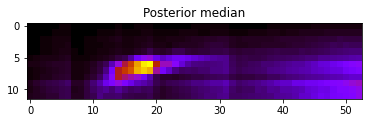

In [14]:
from uq4pk_fit.inference import LightWeightedModel
from uq4pk_fit.inference import ForwardOperator
import uq4pk_src
from simulate_data import load_experiment_data
from make_figures.mcmc_comparison.parameters import DATA_NAME, LMD_MIN, LMD_MAX, DV, REGPARAM
from uq4pk_fit.visualization import plot_distribution_function

datapath = Path(f"data/{DATA_NAME}")
data = load_experiment_data(str(datapath))
samplesfile = Path("out/samples.npy")
ssps = uq4pk_src.model_grids.MilesSSP(lmd_min=LMD_MIN, lmd_max=LMD_MAX)
forward_operator = ForwardOperator(ssps=ssps, dv=DV)
model = LightWeightedModel(y=data.y, y_sd=data.y_sd, forward_operator=forward_operator, theta=data.theta_ref)
model.beta1 = REGPARAM
fitted_model = model.fit()
f_map = fitted_model.f_map * model.weights.reshape(12, 53)



plt.imshow(f_map, cmap="gnuplot")
plt.title("Posterior mean")
plt.show()

Let us compute MAP estimate and posterior mean.

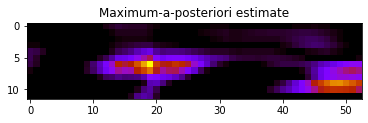

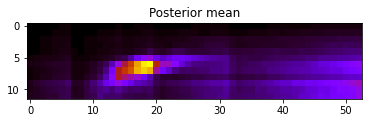

In [15]:
plt.imshow(f_map, cmap="gnuplot")
plt.title("Maximum-a-posteriori estimate")
plt.show()

plt.imshow(posterior_mean, cmap="gnuplot")
plt.title("Posterior mean")
plt.show()

The global structure of both estimates is similar, but there are some differences:
- The MAP is a little bit smoother.
- The MAP shows a distinct clump at the right. This structure is less clear in the posterior mean.

What can explain these differences? Well, on one hand, MAP and posterior mean are simply different
quantities. We expect the MAP to be smoother, since it maximizes the posterior density which includes
the smoothing prior term. However, it is also plausible that the differences are due to poor mixing
of the MCMC method. We can't really tell at this point.


Comparison of filtered credible intervals
-----------------------------------------

We compare the filtered credible intervals that were computed from the samples with the
ones that were computed using optimization.
These filtered

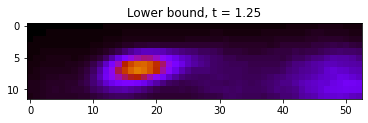

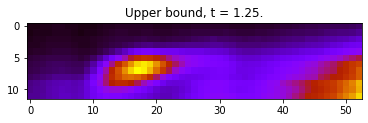

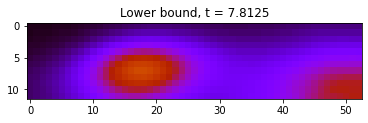

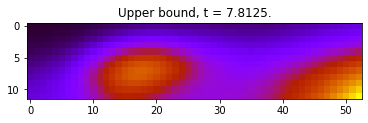

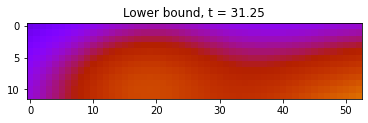

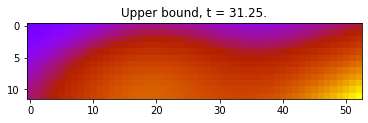

In [7]:
# COMPUTE BLANKET STACK
alpha = 0.05

sigmas = [2., 5., 10.]

for sigma in sigmas:
    sigma_vec = np.array([0.5 * sigma, sigma])
    scale = 0.25 * np.sum(np.square(sigma_vec))
    f_low, f_upp = fitted_model.fci_from_samples(alpha=alpha, samples=beta_samples, options={"sigma": sigma_vec})
    vmin = 0.
    vmax = f_upp.max()
    plt.figure()
    plt.imshow(f_low, cmap="gnuplot", vmin=vmin, vmax=vmax)
    plt.title(f"Lower bound, t = {scale}")
    plt.show()
    plt.figure()
    plt.imshow(f_upp, cmap="gnuplot", vmin=vmin, vmax=vmax)
    plt.title(f"Upper bound, t = {scale}.")
    plt.show()

We observe that the credible intervals are quite tight, even at small scales.

Comparison of blob detection
----------------------------

Next, let us perform some blob detection using the samples. First, let's look at which blobs
are identified in the posterior mean.

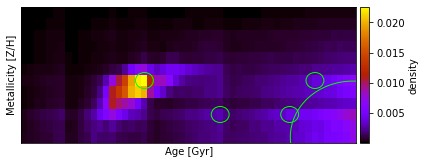

In [8]:
from make_figures.mcmc_comparison.parameters import SIGMA_LIST
from uq4pk_fit.visualization import plot_significant_blobs, plot_blobs
from uq4pk_fit.blob_detection import detect_blobs
%matplotlib inline

mean_blobs = detect_blobs(image=posterior_mean, sigma_list=SIGMA_LIST, rthresh=0.05, max_overlap=0.3)
plot_blobs(image=posterior_mean, blobs=mean_blobs, ssps=ssps, show=True)

The blob detection is not great, because the posterior mean is a little bit noisy. This has
two reasons:
- We perform the regularization in light-weights, which means that the estimate of the
*mass*-weighted distribution function is not necessarily very smooth.
- The posterior mean is a noisy estimate from samples (see above).

Now, let us perform uncertainty-aware blob detection using the filtered credible intervals
computed from the MCMC samples.

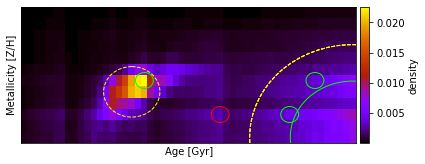

In [10]:
# Load precomputed FCIs.
lower_stack_sampled = np.load(str(Path("out/lower_stack_sampled.npy")))
upper_stack_sampled = np.load(str(Path("out/upper_stack_sampled.npy")))
matched_blobs_sampled = fitted_model.significant_blobs(sigmas=SIGMA_LIST,
                                                       lower_stack=lower_stack_sampled,
                                                       upper_stack=upper_stack_sampled,
                                                       reference_image=posterior_mean,
                                                       rthresh1=0.05,
                                                       rthresh2=0.05,
                                                       overlap1=0.3,
                                                       overlap2=0.8)
plot_significant_blobs(image=posterior_mean, blobs=matched_blobs_sampled, ssps=ssps, show=True)


If we compare this to the ground truth, we see that the two significant blobs correspond to
"true" structures:

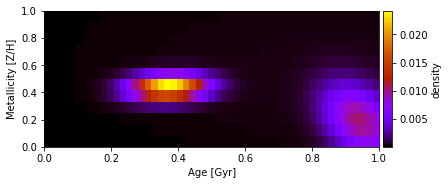

In [12]:
plot_distribution_function(image=data.f_true.reshape(12, 53), show=True)


It is interesting to see that the uncertainty-aware blob detection is robust against the relatively
poor reconstruction.
